# The Backup Coverage Location Problem (LSCP-B)

*Authors:* [Erin Olson](https://github.com/erinrolson), [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

The Backup Coverage Problem is refered to as an extension of the LSCP (Location Set Covering Problem) as it seeks a solution to LSCP while selecting a set of facilities that optimizes for backup coverage (Church and Murray, 2018). If you are unfamiliar with LSCP the following [notebook](lscp.ipynb) explains the problem formulation in detail.

Daskin and Stern (1981) posed the following problem, which Church and Murray (2018) refers to as LSCP-B (Location Set Covering Problem with Backup): _Find the minimum number of facilities and their locations such that each demand is covered, while maximizing the number of backup coverage instances among demand areas._

**LSCP-B can be written as:**

\begin{equation*}
\textbf{Maximize }\sum_{i \in I} U_i
\end{equation*}

___Subject to:___
\begin{equation*}
\sum_{j \in J} a_{ij}Y_j \geq 1 + U_i \quad \forall i \in I
\end{equation*}

\begin{equation*}
\sum_{j \in J} Y_j = p
\end{equation*}

\begin{equation*}
Y_j = \{0, 1\} \quad \forall j \in J
\end{equation*}

\begin{equation*}
U_i \leq 1 \quad \forall i \in I
\end{equation*}

___Where:___

\begin{array}{lcllll}
& & j & \small = & \textrm{index of potential facility sites where } j = 1, 2, . . . , m \\
& & i & \small = & \textrm{index of demand units where } i = 1, 2, . . . , n \\
& & p & \small = & \textrm{objective value identified by using the LSCP} \\
& & U_i & \small = & \begin{cases} 
          1, \text{ if a demand unit is covered twice} \\
          0, \text{ if a demand unit is covered once} \end{cases} \\
& & a_{ij} & \small = & \begin{cases} 
          1, \text{ if facility located at site } j \text{ covers demand unit } i \\
          0, \text{ if not} \end{cases} \\
& & Y_j & \small = & \begin{cases} 
          1, \text{ if a facility is located at potential site } j \\
          0, \text{ otherwise} \end{cases} \\
\end{array}

This tutorial generates synthetic demand (clients) and facility sites near a 10x10 lattice representing a gridded urban core. Three LSCP-B instances are solved while varying parameters and comparing to LSCP solutions:

* `LSCPB.from_cost_matrix()` with network distance as the metric
* `LSCPB.from_geodataframe()` with euclidean distance as the metric
* `LSCPB.from_geodataframe()` with predefined facility locations and euclidean distance as the metric

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2025-04-07T15:05:23.857950-04:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



In [2]:
import warnings

import geopandas
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy
import pulp
import shapely
from matplotlib.patches import Patch

import spopt
from spopt.locate import LSCP, LSCPB, simulated_geo_points

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/spaghetti#649
    import spaghetti

%watermark -w
%watermark -iv

Watermark: 2.5.0

matplotlib: 3.10.1
spopt     : 0.6.2.dev3+g13ca45e
numpy     : 2.2.4
pulp      : 2.8.0
shapely   : 2.1.0
spaghetti : 1.7.6
geopandas : 1.0.1



Since the model needs a distance cost matrix we start with defining our variables. In the comments, it's defined what these variables are for except for solver. The solver, assigned below as `pulp.COIN_CMD`, is an interface to optimization solver developed by [COIN-OR](https://github.com/coin-or/Cbc). If you want to use another optimization interface as Gurobi or CPLEX see this [guide](https://coin-or.github.io/pulp/guides/how_to_configure_solvers.html) that explains how to achieve this.

In [3]:
# quantity demand points
CLIENT_COUNT = 100

# quantity supply points
FACILITY_COUNT = 10

# maximum service radius (in distance units)
SERVICE_RADIUS = 8

# random seeds for reproducibility
CLIENT_SEED = 5
FACILITY_SEED = 6

# set the solver
solver = pulp.COIN_CMD(msg=False, warmStart=True)

## Lattice 10x10

Create a 10x10 lattice with 9 interior lines, both vertical and horizontal.

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

Transform the `spaghetti` instance into a geodataframe.

In [5]:
streets = spaghetti.element_as_gdf(ntw, arcs=True)

In [6]:
streets_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(streets["geometry"].buffer(0.5).union_all()),
    crs=streets.crs,
    columns=["geometry"],
)

Plotting the network created by `spaghetti` we can verify that it mimics a district with quarters and streets.

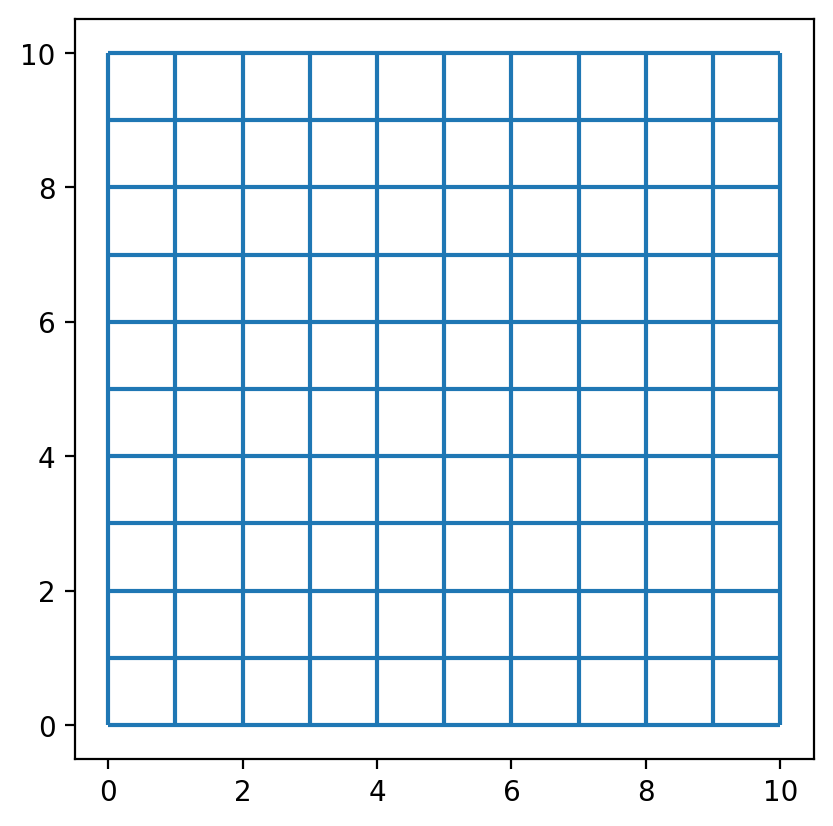

In [7]:
streets.plot();

## Simulate points in a network

The `simulated_geo_points` function simulates points near a network. In this case, it uses the 10x10 lattice network created using the `spaghetti` package. Below we use the function defined above and simulate the points near the lattice edges.

In [8]:
client_points = simulated_geo_points(
    streets_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED
)
facility_points = simulated_geo_points(
    streets_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

Plotting the 100 client and 10 facility points we can see that the function generates dummy points to an area of 10x10, which is the area created by our lattice created on previous cells.

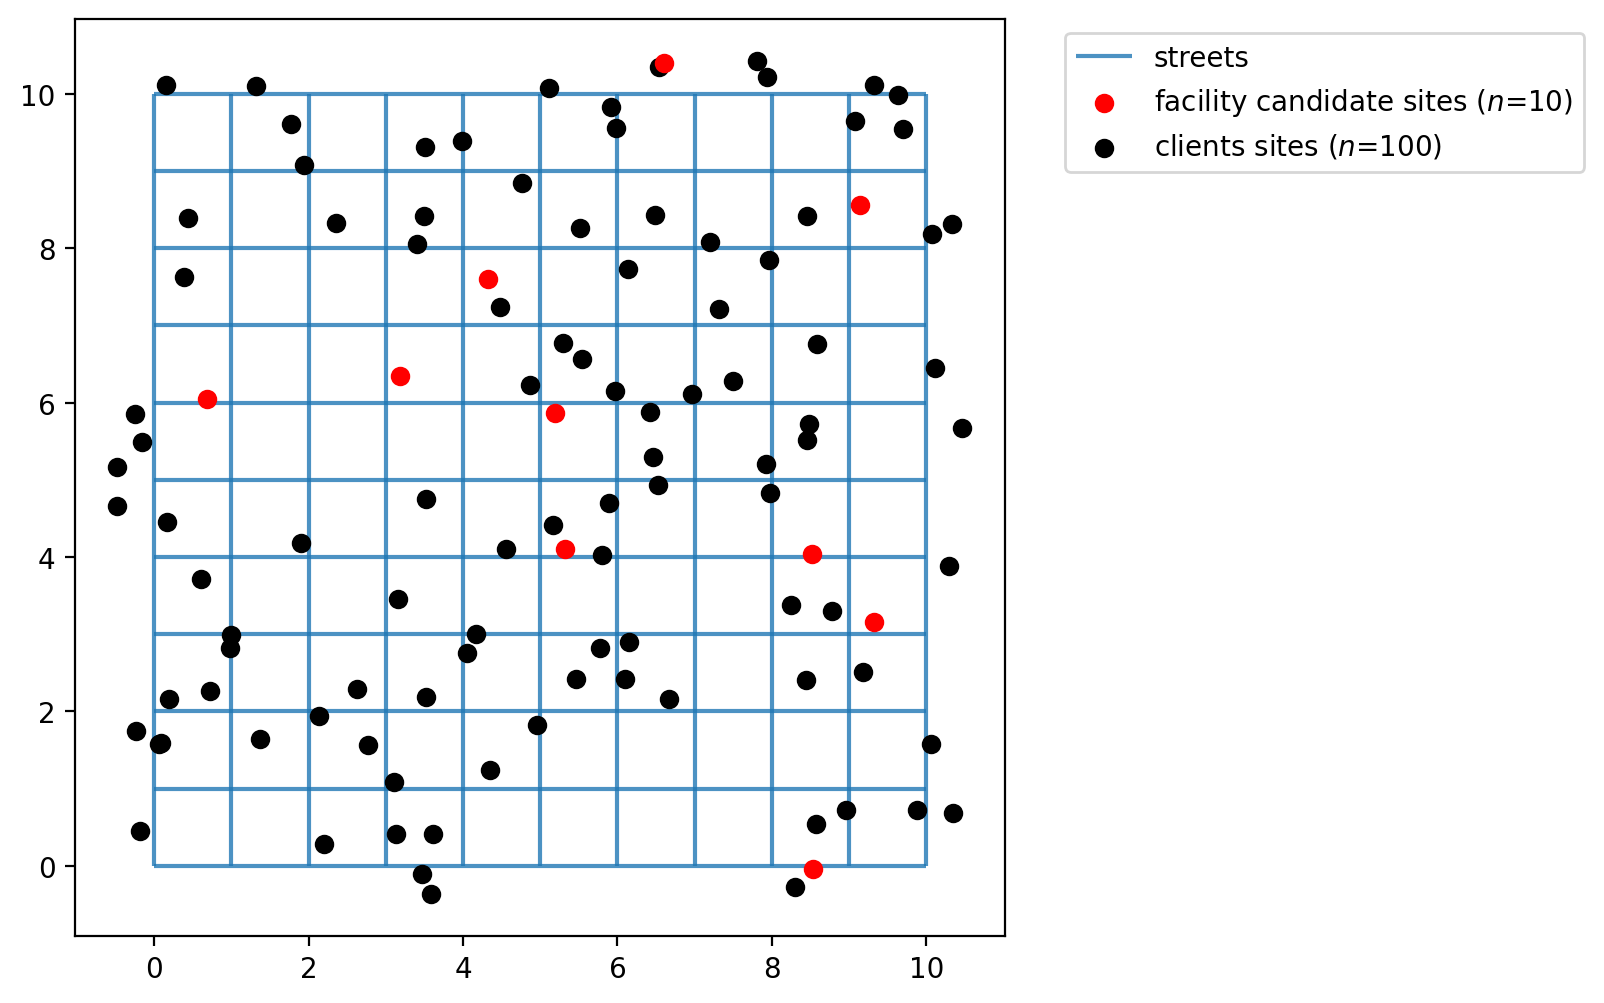

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facility_points.plot(
    ax=ax,
    color="red",
    zorder=2,
    label=f"facility candidate sites ($n$={FACILITY_COUNT})",
)
client_points.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

## Assign simulated points network locations

The simulated client and facility points do not adhere to network space. Calculating distances between them without restricting movement to the network results in a euclidean distances,'as the crow flies.' While this is acceptable for some applications, for others it is more realistic to consider network traversal (e.g. Does a mail carrier follow roads to deliver letters or fly from mailbox to mailbox?).

In our first example we will consider distance along the 10x10 lattice network created above. Therefore, we must first snap the observation points to the network prior to calculating a cost matrix.

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(ntw, pp_name="clients", snapped=True)
clients_snapped.drop(columns=["id", "comp_label"], inplace=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(ntw, pp_name="facilities", snapped=True)
facilities_snapped.drop(columns=["id", "comp_label"], inplace=True)

Now the plot seems more organized as the points occupy network space. The network is plotted below with the network locations of the facility points and clients points.

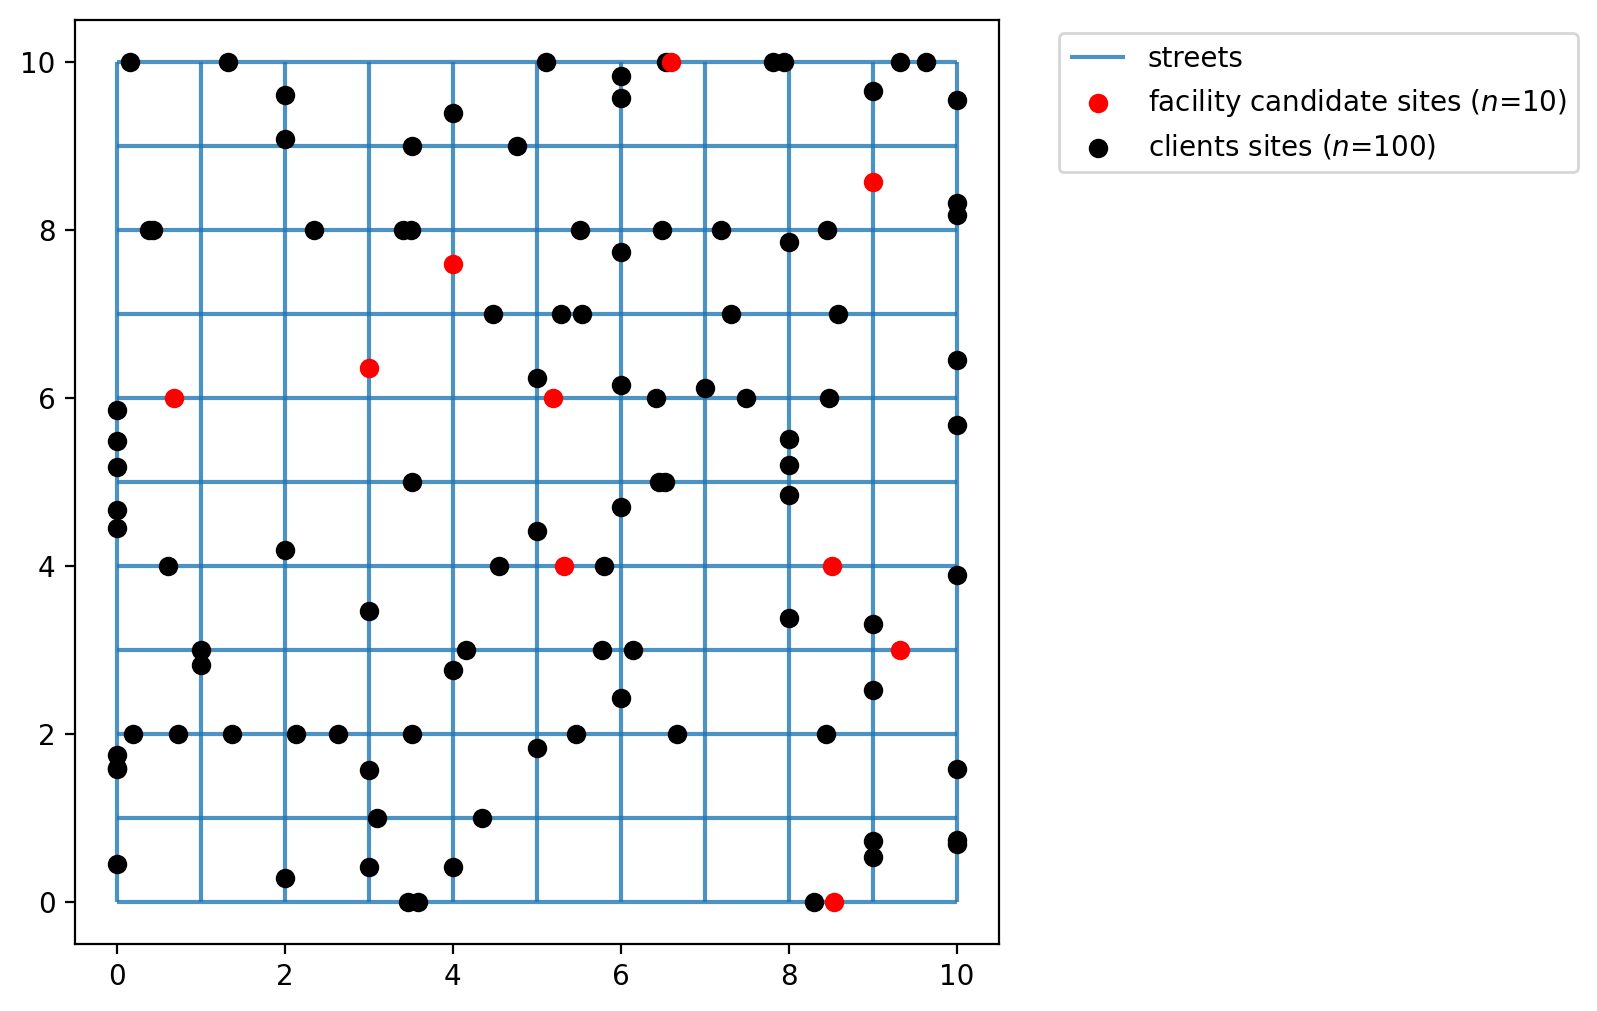

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facilities_snapped.plot(
    ax=ax,
    color="red",
    zorder=2,
    label=f"facility candidate sites ($n$={FACILITY_COUNT})",
)
clients_snapped.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

## Calculating the (network distance) cost matrix
Calculate the network distance between clients and facilities.

In [12]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix.shape

(100, 10)

The expected result here is a network distance between clients and facilities points, in our case a 2D 100x10 array.

In [13]:
cost_matrix[:5, :]

array([[13.39951703, 15.61157572,  4.39383189,  8.40604635,  3.73034161,
         3.4833522 ,  6.2764559 ,  5.52085069, 11.59649553,  7.51670161],
       [13.92618165, 16.13824034,  4.92049651,  8.93271097,  4.25700623,
         4.01001682,  6.80312052,  4.99418607, 12.12316015,  8.04336623],
       [ 7.55064416,  9.76270285,  4.54495901,  2.55717348,  2.57689625,
         2.36552068,  0.42758302,  5.36972356,  5.74762266,  6.33217127],
       [ 3.52405953,  5.73611822,  8.11317865,  3.87460688,  6.14511589,
         6.3921053 ,  3.5990016 ,  6.19849608,  1.72103803,  4.35875589],
       [ 7.75652815,  7.09845387,  6.75084301,  4.76305747,  4.78278024,
         7.02976965,  6.63346702, 12.03397254,  7.95350665, 12.99642024]])

In [14]:
cost_matrix[-5:, :]

array([[ 4.82677859,  7.03883728,  6.8104596 ,  4.16669209,  4.84239683,
         5.08938625,  2.29628254,  4.89577702,  3.02375709,  4.06667068],
       [ 6.47650911,  8.6885678 ,  5.47082397,  2.82705646,  3.5027612 ,
         3.43965572,  0.95664692,  4.44385861,  4.67348761,  5.40630631],
       [10.9188216 , 13.13088029,  4.71841659,  5.92535092,  2.05492631,
         1.00265676,  3.79576046,  5.19626599,  9.1158001 ,  6.15871369],
       [ 3.17082521,  5.3828839 ,  8.46641298,  1.82264547,  6.49835021,
         6.74533963,  3.95223592,  7.74954251,  3.36780371,  8.4107173 ],
       [10.03753584,  6.81744618,  7.0318507 ,  7.04406516,  7.06378793,
         9.31077734,  8.91447471, 14.31498023, 10.23451434, 15.27742793]])

We will solve for both the LSCP and LSCP-B to demonstrate their solution similarities and differences. The ``.from_cost_matrix`` method from each respective model class will be used with the network distance cost matrix calculated above as input to solve each instance. For both models all demand points must be covered by `SERVICE_RADIUS` distance units, but the LSCP-B go one step further and maximizes the likelihood of demand points being covered by more than one service facility. 

In [15]:
lscp_from_cm = LSCP.from_cost_matrix(
    cost_matrix, SERVICE_RADIUS, name="lscp-network-distance"
)
lscp_from_cm = lscp_from_cm.solve(solver)
lscp_from_cm

In [16]:
lscpb_from_cm = LSCPB.from_cost_matrix(
    cost_matrix, SERVICE_RADIUS, solver, name="lscp-b-network-distance"
)
lscpb_from_cm = lscpb_from_cm.solve()
lscpb_from_cm

As stated earlier, the LSCP-B builds on the LSCP. Where the objective of the LSCP is to minimize the number of facilities needed to achieve 100% coverage, the objective of the LSCP-B is to maximize backup coverage *after* solving the LSCP. 

In [17]:
lscp_obj = lscp_from_cm.problem.objective.value()
lscpb_obj = lscpb_from_cm.problem.objective.value()
lscpb_lscp = lscpb_from_cm.lscp_obj_value
lscpb_perc = lscpb_from_cm.backup_perc
print(
    "The minimum number of facilites needed to achieve complete "
    f"coverage within a distance units service radius of {SERVICE_RADIUS} "
    f"are {lscp_obj} and {lscpb_lscp} for the LSCP and LSCP-B, "
    "respectively. However, with the LSCP-B we observe coverage by more "
    f"than one facility at {lscpb_perc}% of client locations."
)

The minimum number of facilites needed to achieve complete coverage within a distance units service radius of 8 are 3.0 and 3.0 for the LSCP and LSCP-B, respectively. However, with the LSCP-B we observe coverage by more than one facility at 80.0% of client locations.


Define the decision variable names used for mapping later.

In [18]:
facility_points["dv"] = lscp_from_cm.fac_vars
facility_points["dv"] = facility_points["dv"].map(lambda x: x.name.replace("_", ""))
facilities_snapped["dv"] = facility_points["dv"]
facility_points

,geometry,dv
0,POINT (9.32146 3.15178),y0
1,POINT (8.53352 -0.04134),y1
2,POINT (0.68422 6.04557),y2
3,POINT (5.32799 4.10688),y3
4,POINT (3.18949 6.34771),y4
5,POINT (4.31956 7.5947),y5
6,POINT (5.1984 5.86744),y6
7,POINT (6.59891 10.39247),y7
8,POINT (8.51844 4.04521),y8
9,POINT (9.13894 8.56135),y9


## Calculating euclidean distance from a `GeoDataFrame`

Now we will use the ``.from_geodataframe`` method from each respective model class to solve each instance. With the ``.from_geodataframe`` method we will calculate a euclidean distance cost matrix as input and consider all 10 candidate locations for potential selection.

In [19]:
distance_metric = "euclidean"
lscp_from_gdf = LSCP.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    SERVICE_RADIUS,
    distance_metric=distance_metric,
    name=f"lscp-{distance_metric}-distance",
)
lscp_from_gdf = lscp_from_gdf.solve(solver)
lscp_from_gdf

In [20]:
distance_metric = "euclidean"
lscpb_from_gdf = LSCPB.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    SERVICE_RADIUS,
    solver,
    distance_metric=distance_metric,
    name=f"lscp-b-{distance_metric}-distance",
)
lscpb_from_gdf = lscpb_from_gdf.solve()
lscpb_from_gdf

In [21]:
lscp_obj = lscp_from_gdf.problem.objective.value()
lscpb_obj = lscpb_from_gdf.problem.objective.value()
lscpb_lscp = lscpb_from_gdf.lscp_obj_value
lscpb_perc = lscpb_from_gdf.backup_perc
print(
    "The minimum number of facilites needed to achieve complete "
    f"coverage within a distance units service radius of {SERVICE_RADIUS} "
    f"are {lscp_obj} and {lscpb_lscp} for the LSCP and LSCP-B, "
    "respectively. However, with the LSCP-B we observe coverage by more "
    f"than one facility at {lscpb_perc}% of client locations."
)

The minimum number of facilites needed to achieve complete coverage within a distance units service radius of 8 are 1.0 and 1.0 for the LSCP and LSCP-B, respectively. However, with the LSCP-B we observe coverage by more than one facility at 0.0% of client locations.


However, in many real world applications there may already be existing facility locations with the goal being to add one or more new facilities. Here we will define facilites $y_4$ and $y_9$ as already existing (they must be present in the model solution). This will lead to a sub-optimal solution.

***Important:*** The facilities in `"predefined_loc"` are a binary array where `1` means the associated location must appear in the solution.

In [22]:
facility_points["predefined_loc"] = 0
facility_points.loc[(4, 9), "predefined_loc"] = 1
facilities_snapped["predefined_loc"] = facility_points["predefined_loc"]
facility_points

,geometry,dv,predefined_loc
0,POINT (9.32146 3.15178),y0,0
1,POINT (8.53352 -0.04134),y1,0
2,POINT (0.68422 6.04557),y2,0
3,POINT (5.32799 4.10688),y3,0
4,POINT (3.18949 6.34771),y4,1
5,POINT (4.31956 7.5947),y5,0
6,POINT (5.1984 5.86744),y6,0
7,POINT (6.59891 10.39247),y7,0
8,POINT (8.51844 4.04521),y8,0
9,POINT (9.13894 8.56135),y9,1


In [23]:
lscp_from_gdf_pre = LSCP.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    SERVICE_RADIUS,
    distance_metric=distance_metric,
    predefined_facility_col="predefined_loc",
    name=f"lscp-{distance_metric}-distance-predefined",
)
lscp_from_gdf_pre = lscp_from_gdf_pre.solve(solver)

In [24]:
lscpb_from_gdf_pre = LSCPB.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    SERVICE_RADIUS,
    solver,
    distance_metric=distance_metric,
    predefined_facility_col="predefined_loc",
    name=f"lscp-b-{distance_metric}-distance-predefined",
)
lscpb_from_gdf_pre = lscpb_from_gdf_pre.solve()

In [25]:
lscp_obj = lscp_from_gdf_pre.problem.objective.value()
lscpb_obj = lscpb_from_gdf_pre.problem.objective.value()
lscpb_lscp = lscpb_from_gdf_pre.lscp_obj_value
lscpb_perc = lscpb_from_gdf_pre.backup_perc
print(
    "The minimum number of facilites needed to achieve complete "
    f"coverage within a distance units service radius of {SERVICE_RADIUS} "
    f"are {lscp_obj} and {lscpb_lscp} for the LSCP and LSCP-B, "
    "respectively. However, with the LSCP-B we observe coverage by more "
    f"than one facility at {lscpb_perc}% of client locations."
)

The minimum number of facilites needed to achieve complete coverage within a distance units service radius of 8 are 3.0 and 3.0 for the LSCP and LSCP-B, respectively. However, with the LSCP-B we observe coverage by more than one facility at 98.0% of client locations.


## Plotting the results

The two cells below describe the plotting of the results. For each method from the `LSCP` and `LSCPB` classes (`.from_cost_matrix()`, `.from_geodataframe()`) there is a plot displaying the facility site that was selected with a star colored and the points covered with the same color. Demand points covered by more than one facility are displayed in overlapping concentric circles.

In [26]:
dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
]
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}
dv_colors

{'y0': 'darkcyan',
 'y1': 'mediumseagreen',
 'y2': 'saddlebrown',
 'y3': 'darkslategray',
 'y4': 'lightskyblue',
 'y5': 'thistle',
 'y6': 'lavender',
 'y7': 'darkgoldenrod',
 'y8': 'peachpuff',
 'y9': 'coral',
 'y10': 'mediumvioletred',
 'y11': 'blueviolet',
 'y12': 'fuchsia',
 'y13': 'cyan',
 'y14': 'limegreen',
 'y15': 'mediumorchid'}

In [27]:
def plot_results(model, p, facs, clis=None, ax=None):
    """Visualize optimal solution sets and context."""
    if not ax:
        multi_plot = False
        fig, ax = plt.subplots(figsize=(6, 6))
        markersize, markersize_factor = 4, 4
    else:
        ax.axis("off")
        multi_plot = True
        markersize, markersize_factor = 2, 2
    ax.set_title(model.name, fontsize=15)

    # extract facility-client relationships for plotting (except for p-dispersion)
    plot_clis = isinstance(clis, geopandas.GeoDataFrame)
    if plot_clis:
        cli_points = {}
    fac_sites = {}
    for i, dv in enumerate(model.fac_vars):
        if dv.varValue:
            dv, predef = facs.loc[i, ["dv", "predefined_loc"]]
            fac_sites[dv] = [i, predef]
            if plot_clis:
                geom = clis.iloc[model.fac2cli[i]]["geometry"]
                cli_points[dv] = geom

    # study area and legend entries initialization
    streets.plot(ax=ax, alpha=1, color="black", zorder=1)
    legend_elements = [mlines.Line2D([], [], color="black", label="streets")]

    if plot_clis and model.name.startswith("mclp"):
        # any clients that not asscociated with a facility
        c = "k"
        if model.n_cli_uncov:
            idx = [i for i, v in enumerate(model.cli2fac) if len(v) == 0]
            pnt_kws = {
                "ax": ax,
                "fc": c,
                "ec": c,
                "marker": "s",
                "markersize": 7,
                "zorder": 2,
            }
            clis.iloc[idx].plot(**pnt_kws)
        _label = f"Demand sites not covered ($n$={model.n_cli_uncov})"
        _mkws = {
            "marker": "s",
            "markerfacecolor": c,
            "markeredgecolor": c,
            "linewidth": 0,
        }
        legend_elements.append(mlines.Line2D([], [], ms=3, label=_label, **_mkws))

    # all candidate facilities
    facs.plot(ax=ax, fc="brown", marker="*", markersize=80, zorder=8)
    _label = f"Facility sites ($n$={len(model.fac_vars)})"
    _mkws = {"marker": "*", "markerfacecolor": "brown", "markeredgecolor": "brown"}
    legend_elements.append(mlines.Line2D([], [], ms=7, lw=0, label=_label, **_mkws))

    # facility-(client) symbology and legend entries
    zorder = 4
    for fname, (fac, predef) in fac_sites.items():
        cset = dv_colors[fname]
        if plot_clis:
            # clients
            geoms = cli_points[fname]
            gdf = geopandas.GeoDataFrame(geoms)
            gdf.plot(ax=ax, zorder=zorder, ec="k", fc=cset, markersize=100 * markersize)
            _label = f"Demand sites covered by {fname}"
            _mkws = {
                "markerfacecolor": cset,
                "markeredgecolor": "k",
                "ms": markersize + 7,
            }
            legend_elements.append(
                mlines.Line2D([], [], marker="o", lw=0, label=_label, **_mkws)
            )
        # facilities
        ec = "k"
        lw = 2
        predef_label = "predefined"
        if model.name.endswith(predef_label) and predef:
            ec = "r"
            lw = 3
            fname += f" ({predef_label})"
        facs.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec=ec, lw=lw
        )
        _mkws = {"markerfacecolor": cset, "markeredgecolor": ec, "markeredgewidth": lw}
        legend_elements.append(
            mlines.Line2D([], [], marker="*", ms=20, lw=0, label=fname, **_mkws)
        )
        # increment zorder up and markersize down for stacked client symbology
        zorder += 1
        if plot_clis:
            markersize -= markersize_factor / p

    if not multi_plot:
        # legend
        kws = {"loc": "upper left", "bbox_to_anchor": (1.05, 0.7)}
        plt.legend(handles=legend_elements, **kws)

### LSCP and LSCP-B built from cost matrix (network distance)

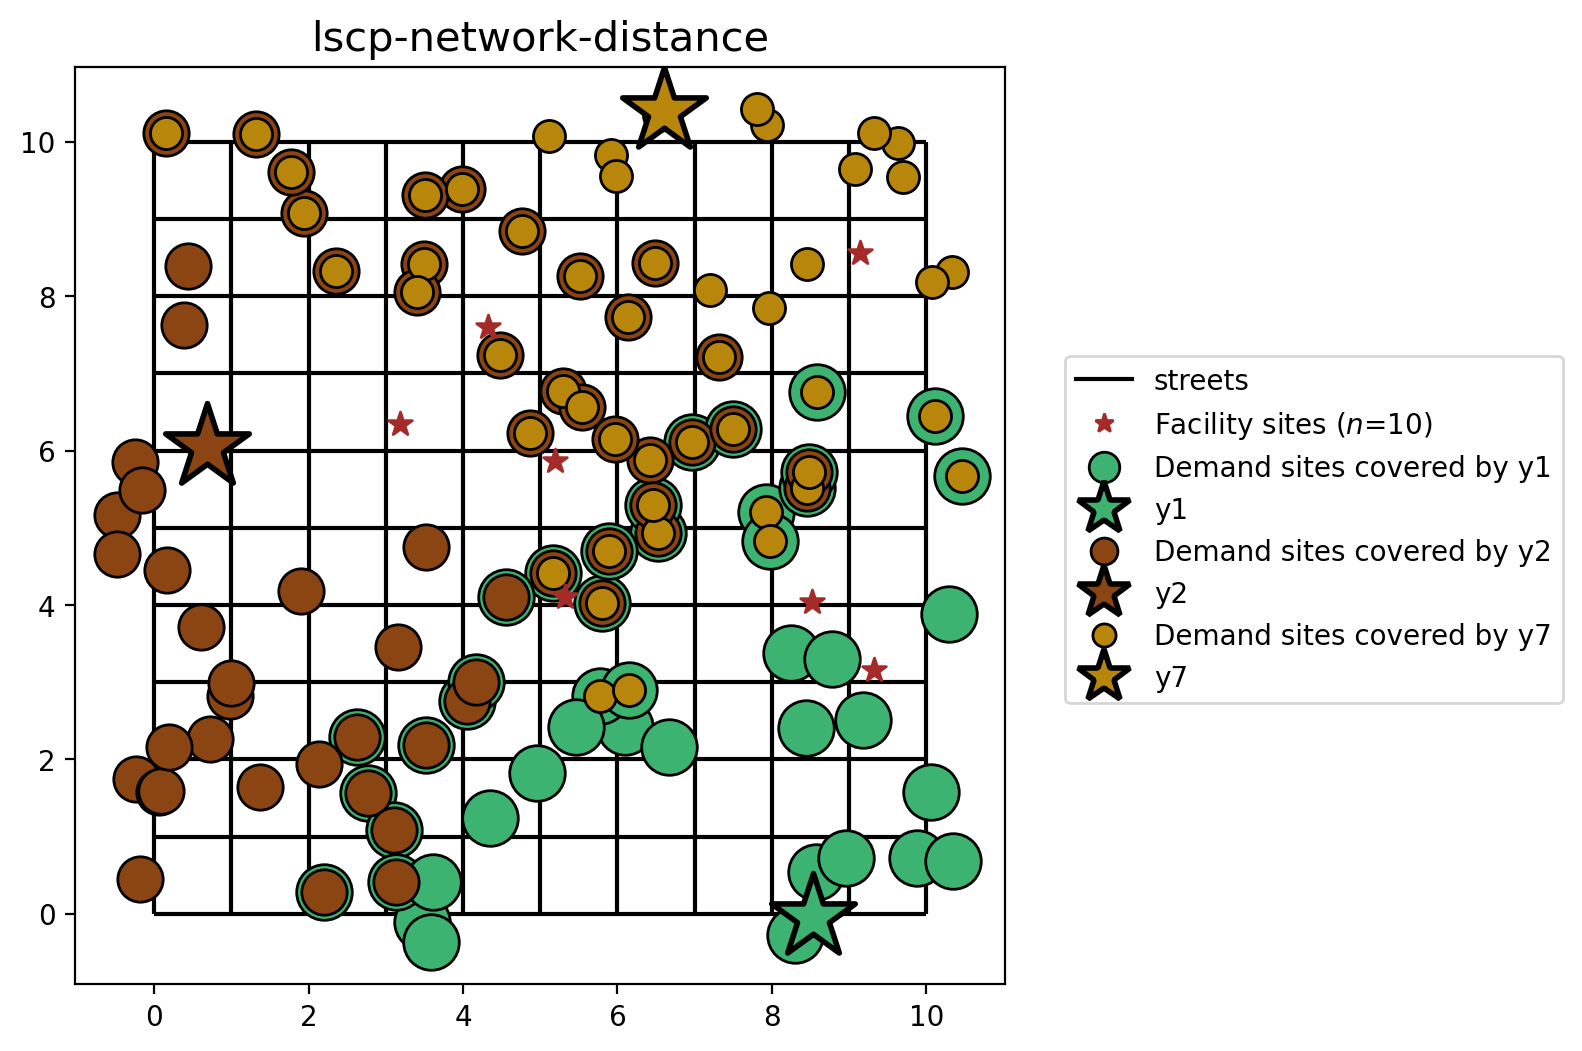

In [28]:
plot_results(
    lscp_from_cm,
    lscp_from_cm.problem.objective.value(),
    facility_points,
    clis=client_points,
)

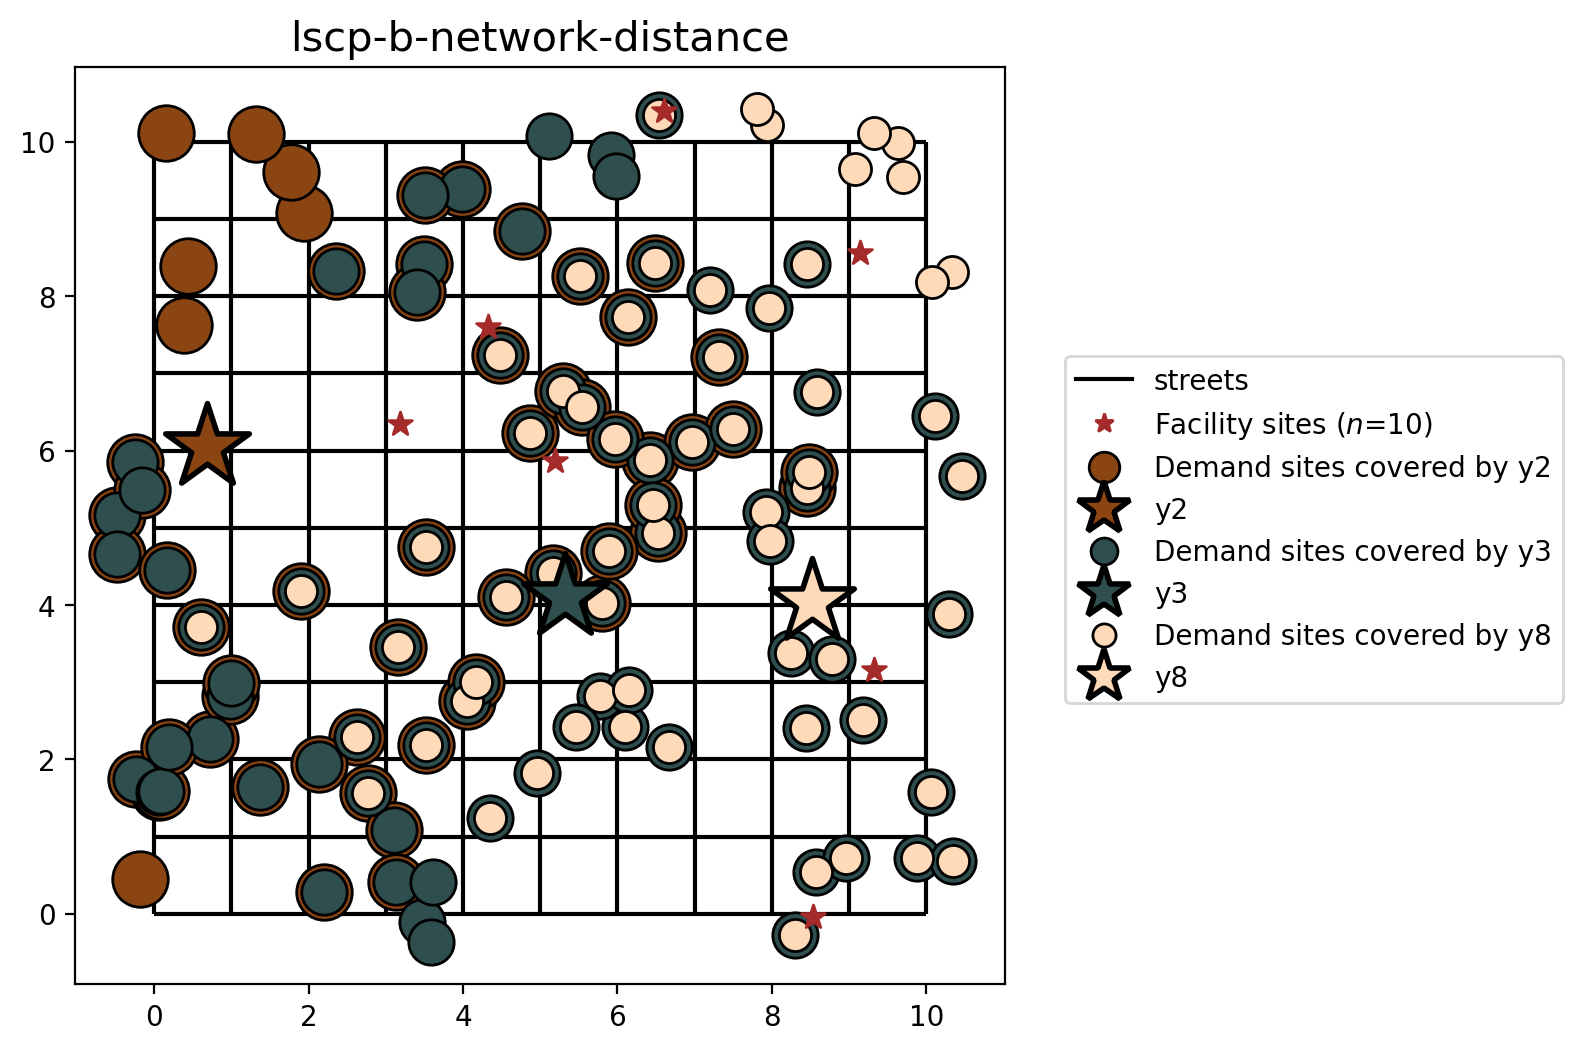

In [29]:
plot_results(
    lscpb_from_cm,
    lscpb_from_cm.lscp_obj_value,
    facility_points,
    clis=client_points,
)

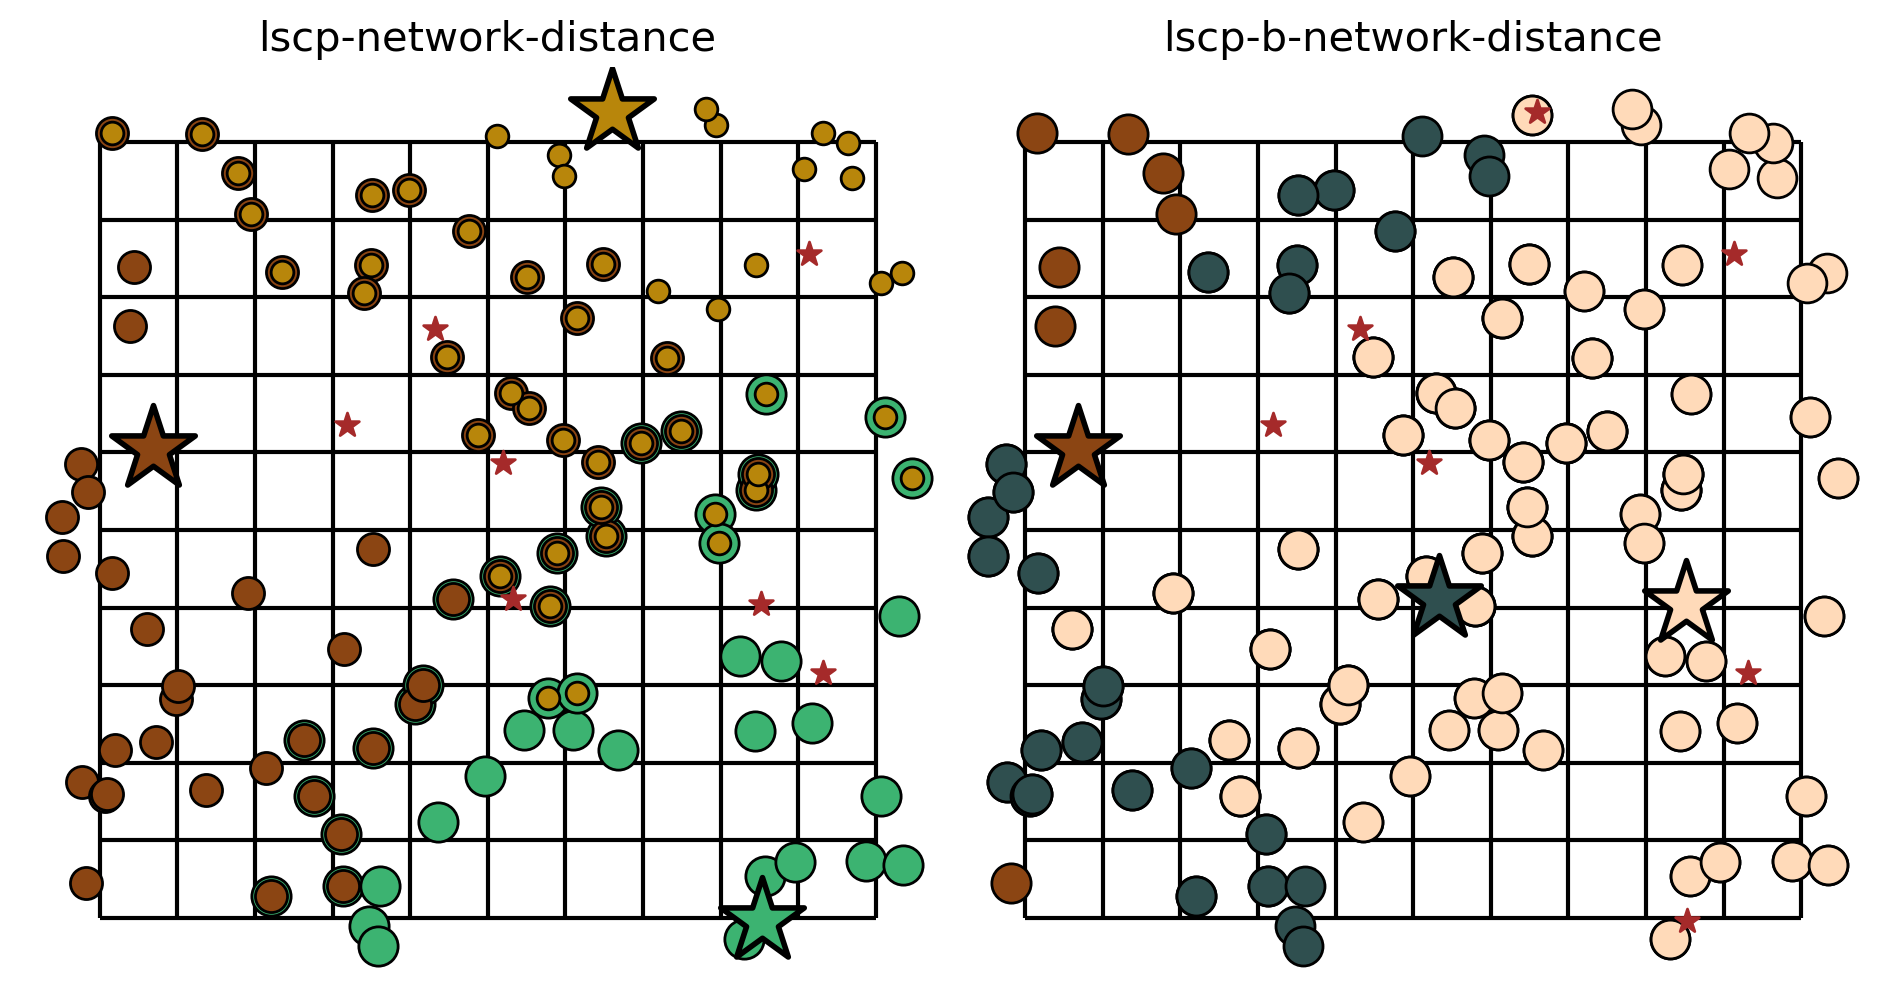

In [30]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=-0.01)
for i, m in enumerate([lscp_from_cm, lscpb_from_cm]):
    _p = m.lscp_obj_value if m.name.startswith("LSCPB") else m.problem.objective.value()
    plot_results(m, _p, facility_points, clis=client_points, ax=axarr[i])

When comparing the selection sets of the LSCP and LSCP-B (based on network distance), we can clearly see the difference. For both, facilities $y_2$ is selected, and cover the same clients in both models. However, the LSCP-B improves upon the LSCP selection set where it is determined that facilities $y_3$ and $y_8$ provides more backup coverage than facilities $y_2$ and $y_7$.


### LSCP and LSCP-B built from geodataframe (euclidean distance)

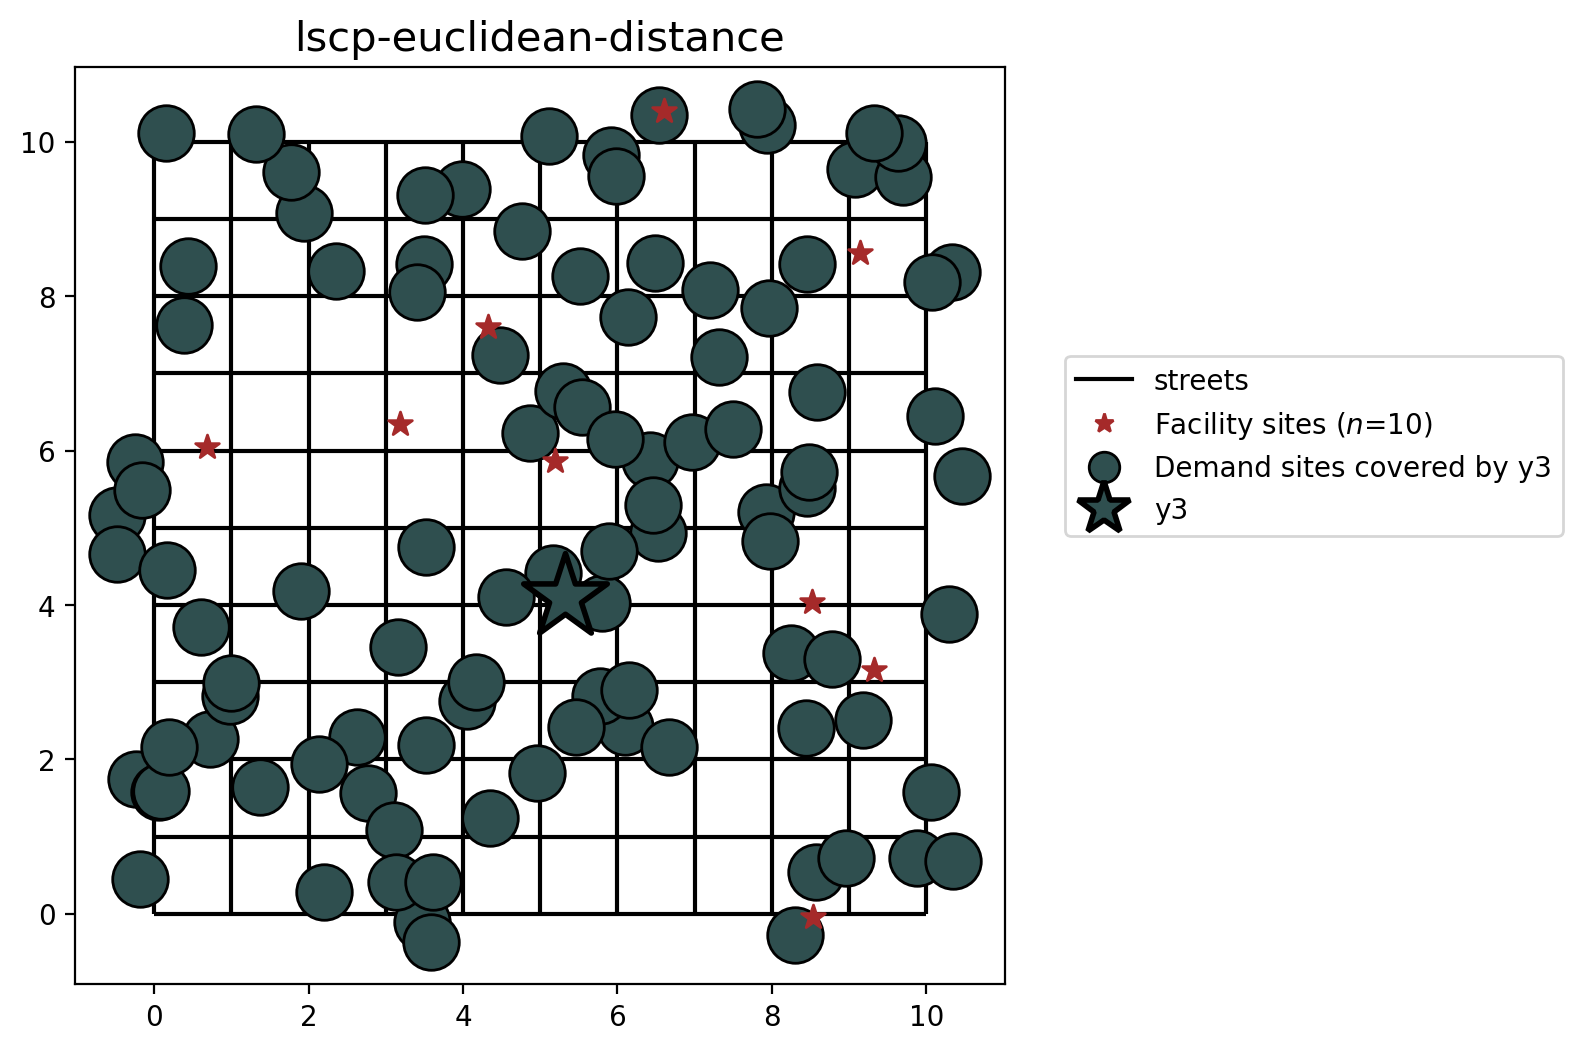

In [31]:
plot_results(
    lscp_from_gdf,
    lscp_from_gdf.problem.objective.value(),
    facility_points,
    clis=client_points,
)

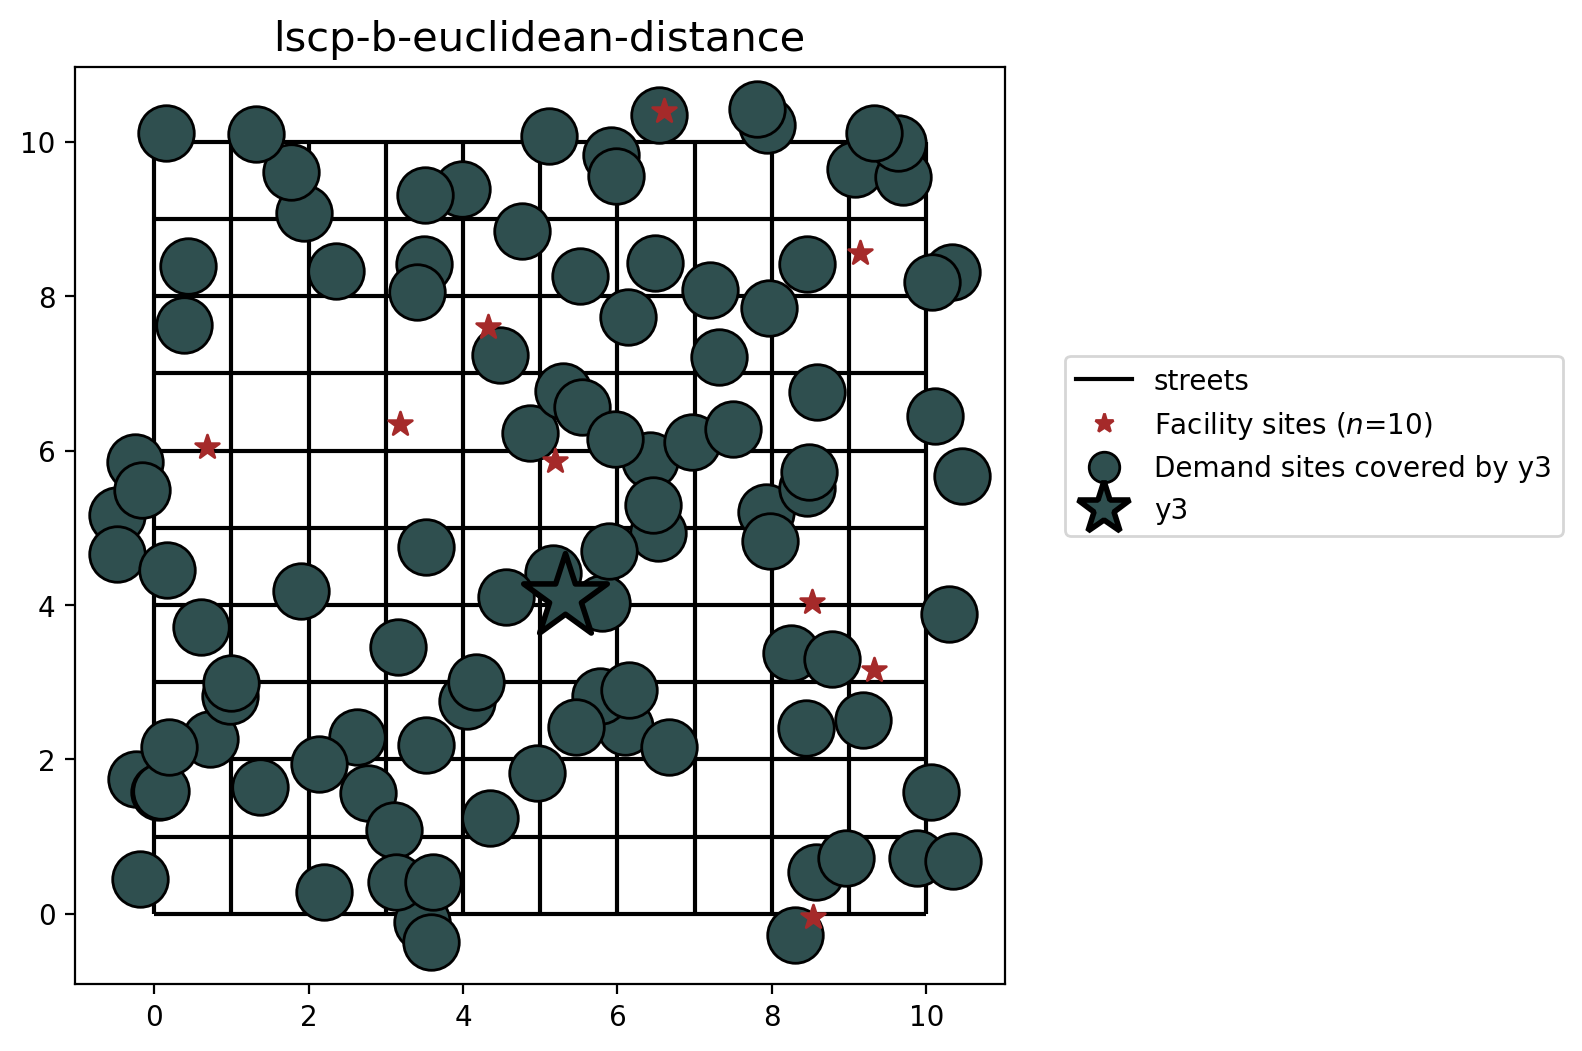

In [32]:
plot_results(
    lscpb_from_gdf,
    lscpb_from_gdf.lscp_obj_value,
    facility_points,
    clis=client_points,
)

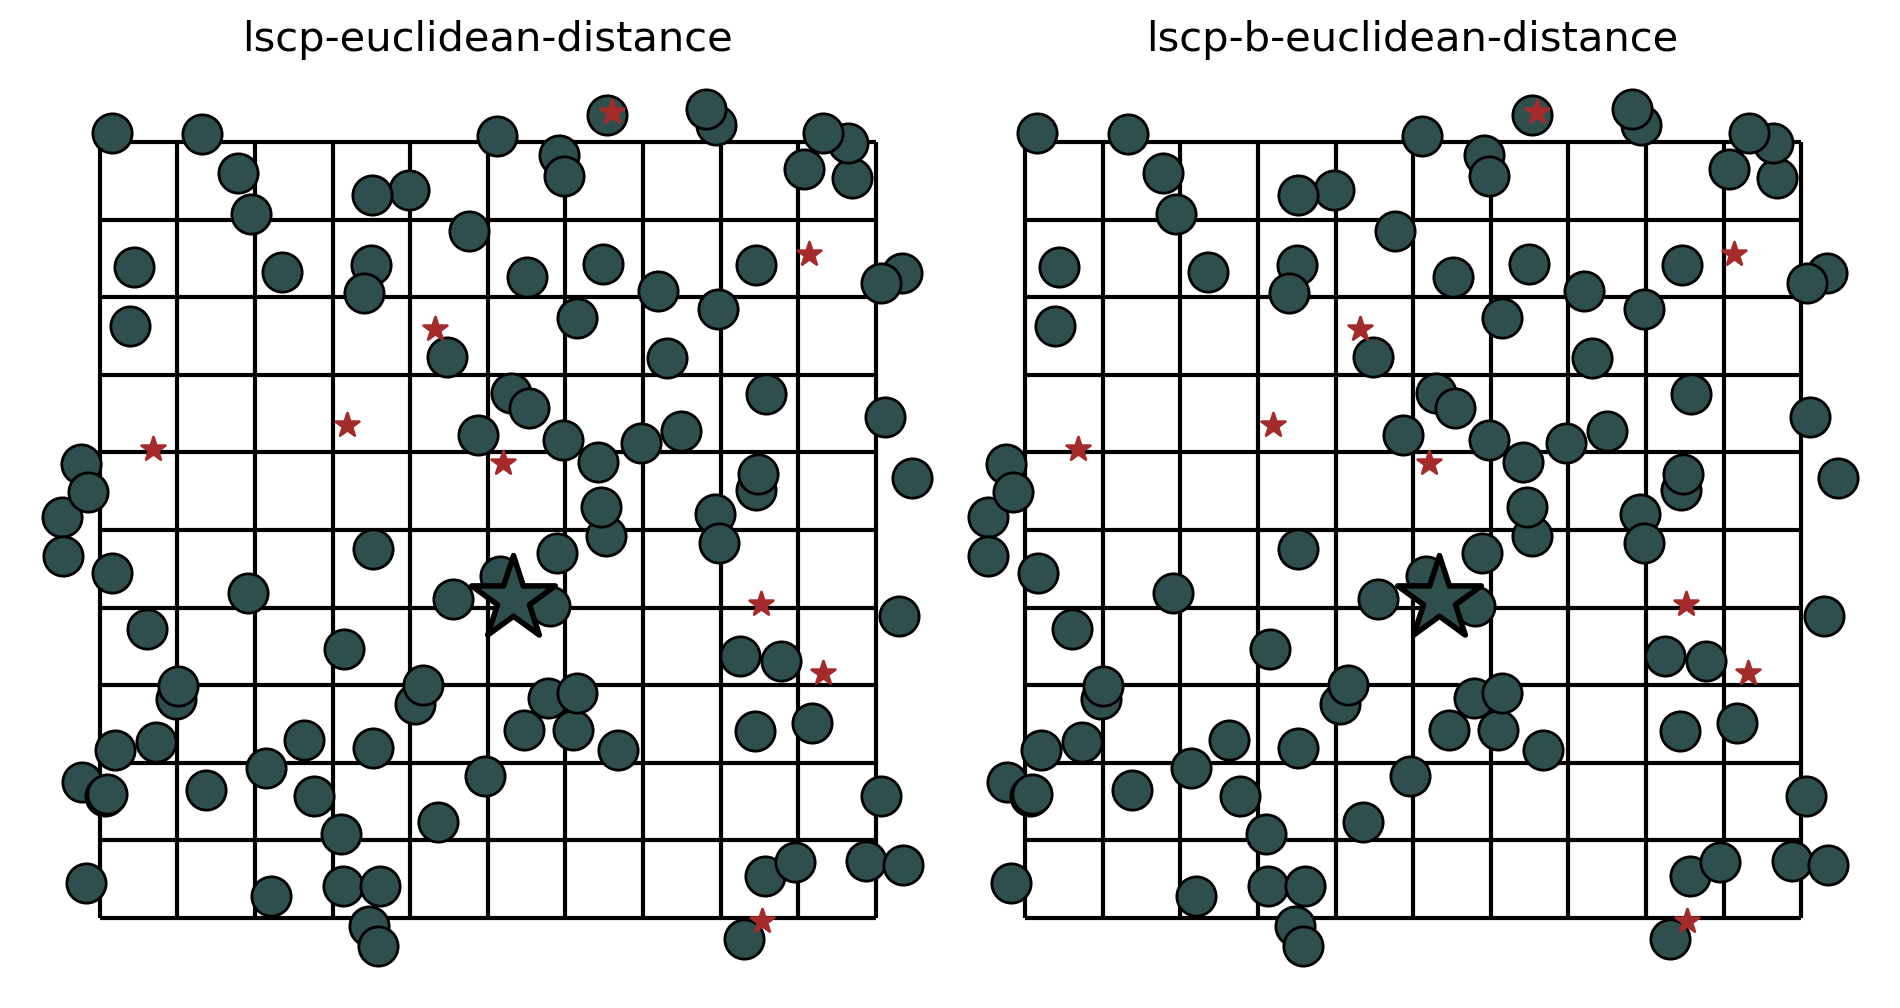

In [33]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=-0.01)
for i, m in enumerate([lscp_from_gdf, lscpb_from_gdf]):
    _p = (
        m.lscp_obj_value if m.name.startswith("lscp-b") else m.problem.objective.value()
    )
    plot_results(m, _p, facility_points, clis=client_points, ax=axarr[i])

But how can just one facility cover all of the demand locations? This can be explained by the nature of the problem. The problem was configured in a synthetic manner, the streets are created as a 10x10 lattice and the `SERVICE_RADIUS` parameter is 8 distance units. Owing to the central location of facility $y_3$, all demand points can be reached within 8 euclidean distance units. Therefore, the LSCP-B is not able to improve upon the results from solving the LSCP.

### LSCP and LSCP-B with preselected facilities (euclidean distance)

Finally, let's visualize the results of the LSCP when stipulating that facilities $y_4$ and $y_9$ must be included in the final selection.

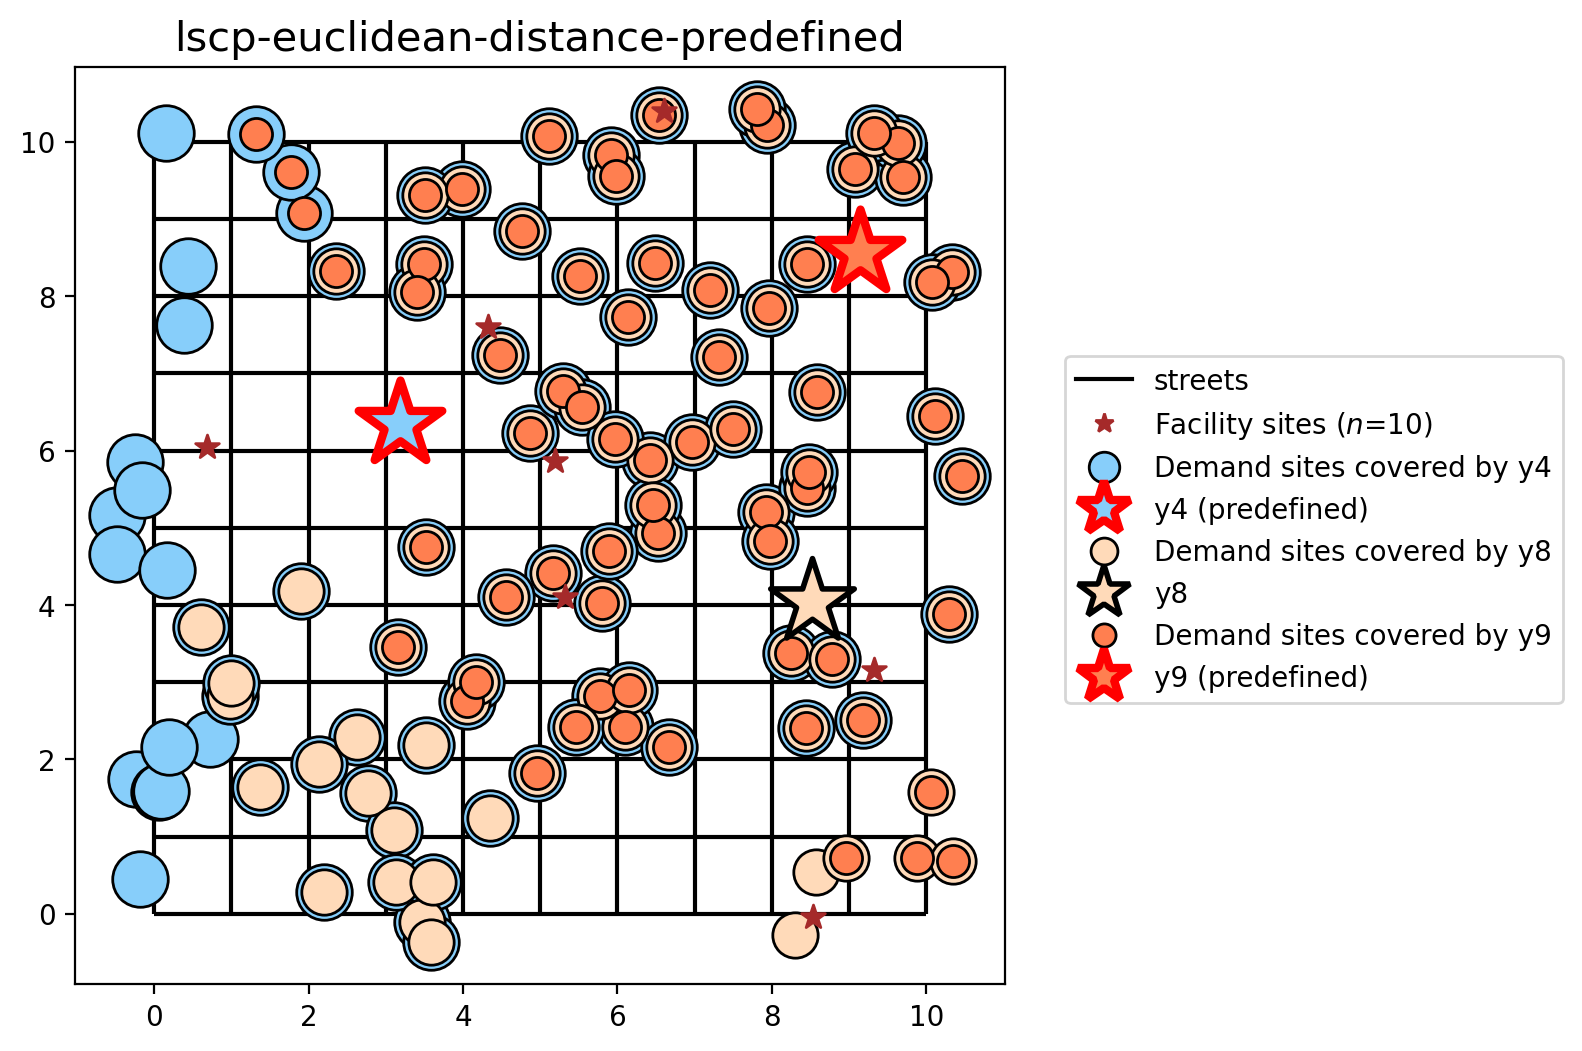

In [34]:
plot_results(
    lscp_from_gdf_pre,
    lscp_from_gdf_pre.problem.objective.value(),
    facility_points,
    clis=client_points,
)

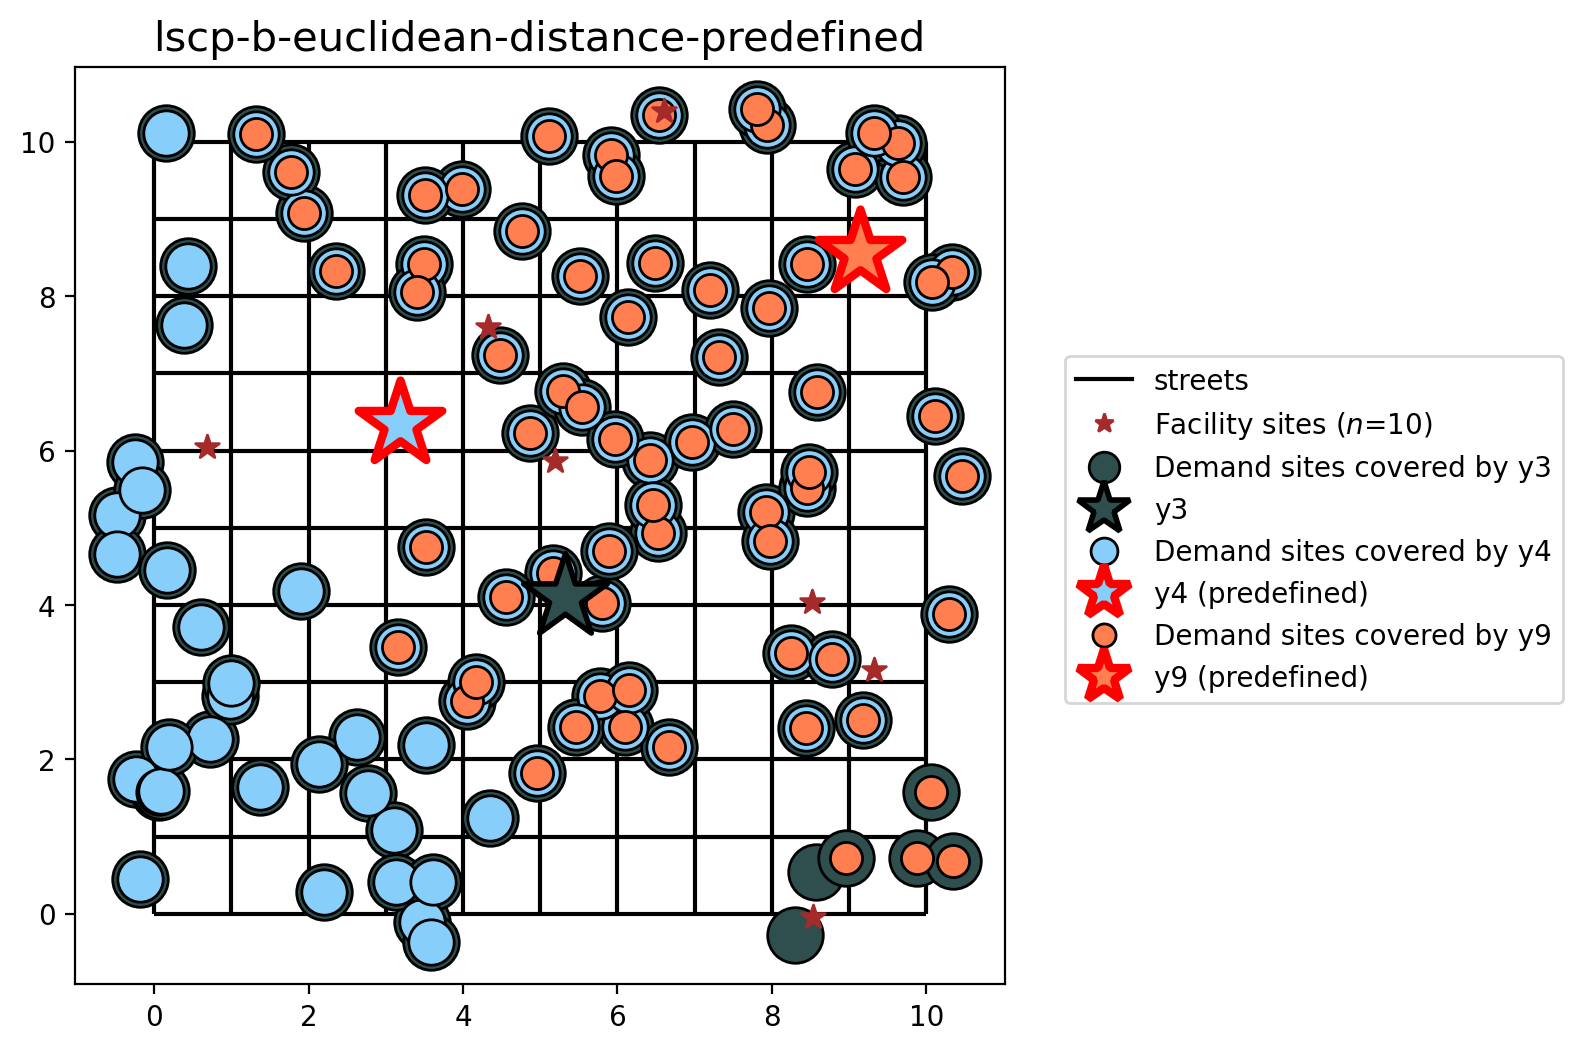

In [35]:
plot_results(
    lscpb_from_gdf_pre,
    lscpb_from_gdf_pre.lscp_obj_value,
    facility_points,
    clis=client_points,
)

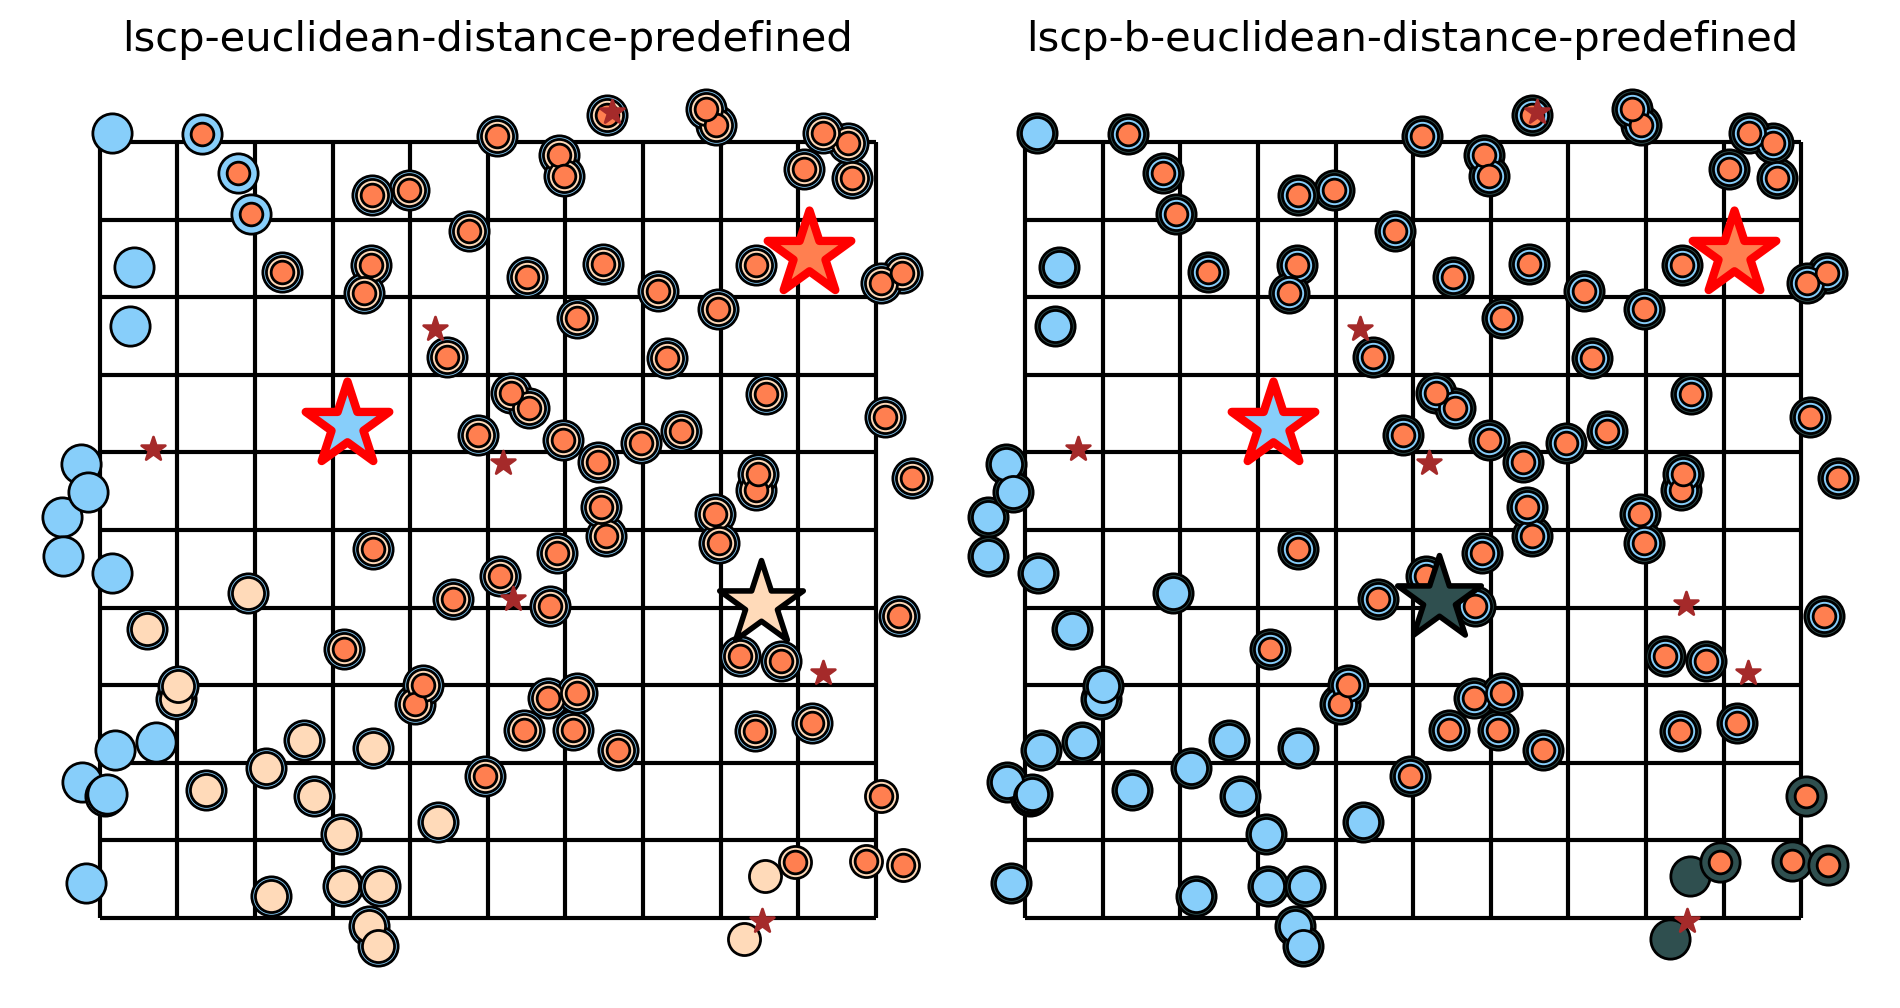

In [36]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=-0.01)
for i, m in enumerate([lscp_from_gdf_pre, lscpb_from_gdf_pre]):
    _p = (
        m.lscp_obj_value if m.name.startswith("lscp-b") else m.problem.objective.value()
    )
    plot_results(m, _p, facility_points, clis=client_points, ax=axarr[i])

Here we stipulated that facilities $y_4$ and $y_9$ were to be included in the 'optimal' solution to the LSCP and LSCP-B based on euclidean distance. Therefore, the solutions diverge wherein the LSCP-B improves upon the LSCP selection set by determining that facility $y_3$ provides more backup coverage than facility $y_8$.

## References

- [Church, R. L., & Murray, A. T. (2018). Location covering models: History, applications and advancements (1st edition 2018). Springer](https://www.springer.com/gb/book/9783319998459)
- [Toregas, C., Swain, R., ReVelle, C., &amp; Bergman, L. (1971). The location of emergency service facilities. Operations Research, 19(6), 1363–1373.](https://pubsonline.informs.org/doi/abs/10.1287/opre.19.6.1363)
- [Daskin MS, Stern EH (1981) A hierarchical objective set covering model for emergency medical
service vehicle deployment.](https://daskin.engin.umich.edu/wp-content/uploads/sites/133/2014/07/daskinandstern_ts1981_.pdf)